In [1]:
import pandas as pd

def print_results_table(csv_results_path, methods):
    # Import required libraries
    

    # Load the CSV data (replace with your actual path if reading from file)

    df = pd.read_csv(csv_results_path,sep='\t')
    # Pivot table: datasets in rows, methods as columns, MAE as values
    mae_table = df.pivot(index='Dataset', columns='Method', values='MAE')

    # filter table so only methods in methods are shown (methods is a tuple)
    mae_table = mae_table[mae_table.columns[mae_table.columns.isin(methods)]]
    # reindex using methods
    mae_table = mae_table.reindex(columns=methods)

    # Function to bold the minimum value in each row
    def highlight_best(s):
        is_min = s == s.min()
        return ['font-weight: bold' if v else '' for v in is_min]

    # Add a row with mean MAE per method
    mae_table.loc['Mean'] = mae_table.mean()

    # Apply the highlighting
    styled = mae_table.style.apply(highlight_best, axis=1).format("{:.5f}")

    # Display the styled table
    return styled






In [2]:
import pandas as pd

def export_results_to_latex(csv_results_path, methods, method_names=None):
    # Load the CSV data
    df = pd.read_csv(csv_results_path, sep='\t')
    
    # Pivot table: datasets in rows, methods as columns, MAE as values
    mae_table = df.pivot(index='Dataset', columns='Method', values='MAE')
    
    # Filter to include only specified methods
    mae_table = mae_table[mae_table.columns[mae_table.columns.isin(methods)]]
    # reindex using methods
    mae_table = mae_table.reindex(columns=methods)

    if method_names is not None:
        # Rename the columns using method_names
        mae_table.columns = method_names
    
    # Add a row with mean MAE per method
    mae_table.loc['Mean'] = mae_table.mean()
    
    # Apply bold formatting to the minimum value in each row
    formatted_rows = []
    for _, row in mae_table.iterrows():
        is_min = row == row.min()
        formatted_row = [f"\\bftab {v:.5f}" if m else f"{v:.5f}" for v, m in zip(row, is_min)]
        formatted_rows.append(formatted_row)
    
    formatted_table = pd.DataFrame(formatted_rows, index=mae_table.index, columns=mae_table.columns)
    formatted_table.index = formatted_table.index.str.replace('_', '\\_', regex=False)

    # Group info
    header_groups = [
        ("Baseline", 1),
        ("E-step mods", 3),
        ("M-step mods", 4)
    ]

    # Build column format (no trailing |)
    column_format = "l"
    for i, (_, count) in enumerate(header_groups):
        column_format += "|" + "c" * count if i > 0 else "c" * count

    # Start LaTeX table
    latex_lines = []
    latex_lines.append(f"\\begin{{tabular}}{{{column_format}}}")
    latex_lines.append("\\toprule")

    # First header row: method groups
    header_line1 = [""]  # Dataset column
    for i, (group_name, count) in enumerate(header_groups):
        group_spec = "c" if i == len(header_groups) - 1 else "c|"
        header_line1.append(f"\\multicolumn{{{count}}}{{{group_spec}}}{{{group_name}}}")
    latex_lines.append(" & ".join(header_line1) + " \\\\")

    # Second header row: method names
    header_line2 = [""] + list(formatted_table.columns)
    latex_lines.append(" & ".join(header_line2) + " \\\\")
    latex_lines.append("\\midrule")

    # Table body
    for idx, row in formatted_table.iterrows():
        if idx == "Mean":
            latex_lines.append("\\hline")
        line = [idx] + list(row)
        latex_lines.append(" & ".join(line) + " \\\\")

    latex_lines.append("\\bottomrule")
    latex_lines.append("\\end{tabular}")

    return "\n".join(latex_lines)


## Multiclass results

In [51]:
def get_em_variations(classifier):
    """
    Returns a tuple of EM variations for the given classifier.
    """
    return (
        f'EM_{classifier}',
        f'EM_BCTS_{classifier}',
        f'DEM_{classifier}',
        f'PSEM_{classifier}',
        f'TSEM_{classifier}',
        #f'EREM_{classifier}',
        f'EREMv2_{classifier}',
        f'DMAPEM_{classifier}',
        f'CSEM_{classifier}'
    )
    

for classifier in ('LR','NN'):
    display(print_results_table('results/ucimulti/allmethods.csv',get_em_variations(classifier)))



Method,EM_LR,EM_BCTS_LR,DEM_LR,PSEM_LR,TSEM_LR,EREMv2_LR,DMAPEM_LR,CSEM_LR
Dataset,,,,,,,,
abalone,0.07071,0.07462,0.05406,0.07096,0.07071,0.05730,0.05397,0.07464
academic-success,0.03074,0.03184,0.03068,0.03089,0.03074,0.03074,0.04146,0.02459
chess,0.03563,0.03516,0.02988,0.03554,0.03563,0.03563,0.02903,0.03614
cmc,0.09456,0.11260,0.08970,0.09472,0.09456,0.09456,0.08983,0.08730
connect-4,0.03653,0.03489,0.03328,0.03654,0.03653,0.03653,0.03403,0.03315
digits,0.00271,0.00270,0.00273,0.00271,0.00266,0.00271,0.00271,0.00269
dry-bean,0.00425,0.00409,0.00420,0.00404,0.00425,0.00425,0.00421,0.00404
hand_digits,0.00286,0.00295,0.00285,0.00286,0.00286,0.00286,0.00286,0.00371
hcv,0.20780,0.30409,0.19215,0.20780,0.18163,0.16233,0.19757,0.20378


Method,EM_NN,EM_BCTS_NN,DEM_NN,PSEM_NN,TSEM_NN,EREMv2_NN,DMAPEM_NN,CSEM_NN
Dataset,,,,,,,,
abalone,0.07295,0.07542,0.06124,0.07295,0.07137,0.05698,0.06132,0.08179
academic-success,0.10913,0.06001,0.10913,0.10907,0.07127,0.10913,0.10913,0.11400
chess,0.01105,0.01071,0.01105,0.01096,0.01105,0.01105,0.01105,0.01521
cmc,0.09280,0.13389,0.09282,0.09278,0.09239,0.09280,0.09280,0.09537
connect-4,0.08971,0.10404,0.08973,0.08954,0.14575,0.09591,0.09021,0.13237
digits,0.00211,0.00219,0.00211,0.00210,0.00211,0.00211,0.00211,0.00224
dry-bean,0.00361,0.00377,0.00361,0.00361,0.00361,0.00361,0.00361,0.00424
hand_digits,0.00096,0.00105,0.00096,0.00096,0.00093,0.00096,0.00096,0.00119
hcv,0.16811,0.30233,0.16811,0.16811,0.16911,0.16811,0.16811,0.16792


In [52]:
print(export_results_to_latex('results/ucimulti/allmethods.csv',('EM_LR','EM_BCTS_LR','PSEM_LR','TSEM_LR','DMAPEM_LR','DEM_LR','CSEM_LR','EREMv2_LR'),('EMQ','Calib','Smooth','Temp','MAP','Damp','Conf','Ent')))
print(export_results_to_latex('results/ucimulti/allmethods.csv',('EM_NN','EM_BCTS_NN','PSEM_NN','TSEM_NN','DMAPEM_NN','DEM_NN','CSEM_NN','EREMv2_NN'),('EMQ','Calib','Smooth','Temp','MAP','Damp','Conf','Ent')))

\begin{tabular}{lc|ccc|cccc}
\toprule
 & \multicolumn{1}{c|}{Baseline} & \multicolumn{3}{c|}{E-step mods} & \multicolumn{4}{c}{M-step mods} \\
 & EMQ & Calib & Smooth & Temp & MAP & Damp & Conf & Ent \\
\midrule
abalone & 0.07071 & 0.07462 & 0.07096 & 0.07071 & \bftab 0.05397 & 0.05406 & 0.07464 & 0.05730 \\
academic-success & 0.03074 & 0.03184 & 0.03089 & 0.03074 & 0.04146 & 0.03068 & \bftab 0.02459 & 0.03074 \\
chess & 0.03563 & 0.03516 & 0.03554 & 0.03563 & \bftab 0.02903 & 0.02988 & 0.03614 & 0.03563 \\
cmc & 0.09456 & 0.11260 & 0.09472 & 0.09456 & 0.08983 & 0.08970 & \bftab 0.08730 & 0.09456 \\
connect-4 & 0.03653 & 0.03489 & 0.03654 & 0.03653 & 0.03403 & 0.03328 & \bftab 0.03315 & 0.03653 \\
digits & 0.00271 & 0.00270 & 0.00271 & \bftab 0.00266 & 0.00271 & 0.00273 & 0.00269 & 0.00271 \\
dry-bean & 0.00425 & 0.00409 & \bftab 0.00404 & 0.00425 & 0.00421 & 0.00420 & \bftab 0.00404 & 0.00425 \\
hand\_digits & 0.00286 & 0.00295 & 0.00286 & 0.00286 & 0.00286 & \bftab 0.00285 & 0.00371 

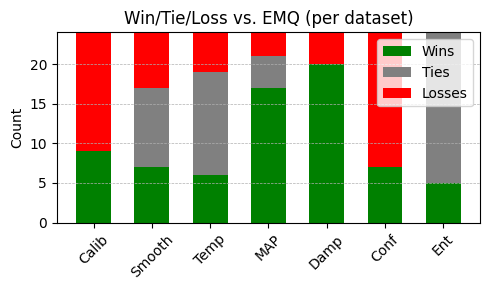

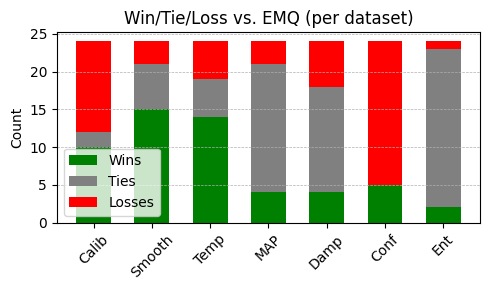

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_win_tie_loss(exp, csv_results_path, method_names, display_labels, baseline_method, tie_tolerance=1e-6):
    """
    Generate a stacked bar chart showing win/tie/loss counts per method vs. baseline (EMQ).

    Parameters:
        csv_results_path (str): Path to the CSV file.
        method_names (list): List of method IDs to evaluate (excluding baseline).
        display_labels (list): Labels to show on the x-axis.
        baseline_method (str): Method name used as the baseline for comparison.
        tie_tolerance (float): Allowed tolerance for ties.
    """
    assert len(method_names) == len(display_labels), "Method names and labels must match"

    # Load and pivot data
    df = pd.read_csv(csv_results_path, sep='\t')
    df = df[df['Method'].isin(method_names + [baseline_method])]
    pivot = df.pivot(index='Dataset', columns='Method', values='MAE')

    # Initialize counters
    wins, ties, losses = [], [], []

    for m in method_names:
        diff = pivot[baseline_method] - pivot[m]
        wins.append((diff > tie_tolerance).sum())
        ties.append((diff.abs() <= tie_tolerance).sum())
        losses.append((diff < -tie_tolerance).sum())

    # Create bar chart
    x = np.arange(len(display_labels))
    width = 0.6

    plt.figure(figsize=(5, 3))
    plt.bar(x, wins, width, label='Wins', color='green')
    plt.bar(x, ties, width, bottom=wins, label='Ties', color='gray')
    plt.bar(x, losses, width, bottom=np.array(wins)+np.array(ties), label='Losses', color='red')

    plt.xticks(x, display_labels, rotation=45)
    plt.ylabel("Count")
    plt.title("Win/Tie/Loss vs. EMQ (per dataset)")
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.savefig("win_tie_loss_summary_{}.pdf".format(exp), format="pdf", bbox_inches="tight")
    plt.show()


methods = ['EM_LR','EM_BCTS_LR','PSEM_LR','TSEM_LR','DMAPEM_LR','DEM_LR','CSEM_LR','EREMv2_LR']
labels = ['EMQ','Calib','Smooth','Temp','MAP','Damp','Conf','Ent']
methods_no_emq = methods[1:]
labels_no_emq = labels[1:]

plot_win_tie_loss(
    'LR',
    'results/ucimulti/allmethods.csv',
    methods_no_emq,
    labels_no_emq,
    baseline_method=methods[0]  # e.g., 'EM_LR'
)

methods = ['EM_NN','EM_BCTS_NN','PSEM_NN','TSEM_NN','DMAPEM_NN','DEM_NN','CSEM_NN','EREMv2_NN']
labels = ['EMQ','Calib','Smooth','Temp','MAP','Damp','Conf','Ent']
methods_no_emq = methods[1:]
labels_no_emq = labels[1:]

plot_win_tie_loss(
    'NN',
    'results/ucimulti/allmethods.csv',
    methods_no_emq,
    labels_no_emq,
    baseline_method=methods[0]  # e.g., 'EM_LR'
)